In [1]:
import numpy as np
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh 

class Block:
    def __init__(self, length, basis_size, operator_dict):
        self.length = length
        self.basis_size = basis_size
        self.operator_dict = operator_dict

class EnlargedBlock:
    def __init__(self, length, basis_size, operator_dict):
        self.length = length
        self.basis_size = basis_size
        self.operator_dict = operator_dict

def is_valid_block(block):
    return all(op.shape == (block.basis_size, block.basis_size) for op in block.operator_dict.values())

is_valid_enlarged_block = is_valid_block

model_d = 2  # Single-site basis size

Sz1 = np.array([[0.5, 0], [0, -0.5]], dtype='d')  # Single-site S^z
Sp1 = np.array([[0, 1], [0, 0]], dtype='d')  # Single-site S^+
H1 = np.array([[0, 0], [0, 0]], dtype='d')  # Single-site portion of H is zero

def H2(Sz1, Sp1, Sz2, Sp2):
    J, Jz = 1., 1.
    return (J / 2) * (kron(Sp1, Sp2.T.conj()) + kron(Sp1.T.conj(), Sp2)) + Jz * kron(Sz1, Sz2)

initial_block = Block(1, model_d, {"H": H1, "conn_Sz": Sz1, "conn_Sp": Sp1})

def enlarge_block(block):
    mblock = block.basis_size
    o = block.operator_dict

    enlarged_operator_dict = {
        "H": kron(o["H"], identity(model_d)) + kron(identity(mblock), H1) + H2(o["conn_Sz"], o["conn_Sp"], Sz1, Sp1),
        "conn_Sz": kron(identity(mblock), Sz1),
        "conn_Sp": kron(identity(mblock), Sp1),
    }

    return EnlargedBlock(block.length + 1, block.basis_size * model_d, enlarged_operator_dict)

def rotate_and_truncate(operator, transformation_matrix):
    T_conj_transpose = transformation_matrix.T.conj()
    return T_conj_transpose @ operator @ transformation_matrix

In [2]:
def enlarge_blocks(sys, env):
    """Enlarge system and environment blocks."""
    sys_enl = enlarge_block(sys)
    env_enl = enlarge_block(env) if sys is not env else sys_enl
    return sys_enl, env_enl

def construct_superblock_hamiltonian(sys_enl, env_enl):
    """Construct the full superblock Hamiltonian."""
    return kron(sys_enl.operator_dict["H"], identity(env_enl.basis_size)) + \
           kron(identity(sys_enl.basis_size), env_enl.operator_dict["H"]) + \
           H2(sys_enl.operator_dict["conn_Sz"], sys_enl.operator_dict["conn_Sp"],
              env_enl.operator_dict["conn_Sz"], env_enl.operator_dict["conn_Sp"])

def calculate_ground_state(superblock_hamiltonian):
    """Calculate the ground state using ARPACK."""
    (energy,), psi0 = eigsh(superblock_hamiltonian, k=1, which="SA")
    return energy, psi0

def reduced_density_matrix(sys_enl, psi0):
    """Construct the reduced density matrix of the system."""
    psi0 = psi0.reshape([sys_enl.basis_size, -1], order="C")
    return np.dot(psi0, psi0.T.conj())

def sort_eigenstates(evals, evecs):
    """Sort eigenvectors by eigenvalue."""
    return sorted(zip(evals, evecs.T), reverse=True, key=lambda x: x[0])

def build_transformation_matrix(eigenstates, m, sys_enl):
    """Build the transformation matrix from the most significant eigenvectors."""
    my_m = min(len(eigenstates), m)
    transformation_matrix = np.zeros((sys_enl.basis_size, my_m), dtype='d', order='F')
    for i, (_, evec) in enumerate(eigenstates[:my_m]):
        transformation_matrix[:, i] = evec
    truncation_error = 1 - sum(eigenvalue for eigenvalue, _ in eigenstates[:my_m])
    print("truncation error:", truncation_error)
    return transformation_matrix, my_m

def rotate_truncate_operators(transformation_matrix, sys_enl):
    """Rotate and truncate each operator."""
    new_operator_dict = {name: rotate_and_truncate(op, transformation_matrix)
                         for name, op in sys_enl.operator_dict.items()}
    return new_operator_dict

def single_dmrg_step(sys, env, m):
    global energies
    assert is_valid_block(sys) and is_valid_block(env)

    sys_enl, env_enl = enlarge_blocks(sys, env)
    assert is_valid_enlarged_block(sys_enl) and is_valid_enlarged_block(env_enl)

    superblock_hamiltonian = construct_superblock_hamiltonian(sys_enl, env_enl)
    energy, psi0 = calculate_ground_state(superblock_hamiltonian)
    rho = reduced_density_matrix(sys_enl, psi0)

    evals, evecs = np.linalg.eigh(rho)
    eigenstates = sort_eigenstates(evals, evecs)
    transformation_matrix, my_m = build_transformation_matrix(eigenstates, m, sys_enl)

    new_operator_dict = rotate_truncate_operators(transformation_matrix, sys_enl)
    newblock = Block(length=sys_enl.length, basis_size=my_m, operator_dict=new_operator_dict)
    energies.append(energy)
    return newblock, energy

In [3]:
def graphic_representation(sys_block, env_block, system_on_left=True):
    """Returns a graphical representation of the DMRG step."""
    graphic = ("=" * sys_block.length) + "**" + ("-" * env_block.length)
    return graphic if system_on_left else graphic[::-1]

def initialize_blocks(L, m_warmup, initial_block):
    """Initialize blocks using the infinite system algorithm."""
    block_disk = {}
    block = initial_block
    block_disk["l", block.length] = block
    block_disk["r", block.length] = block

    while 2 * block.length < L:
        print(graphic_representation(block, block))
        block, energy = single_dmrg_step(block, block, m=m_warmup)
        print("E/L =", energy / (block.length * 2))
        block_disk["l", block.length] = block
        block_disk["r", block.length] = block

    return block_disk, block

def perform_sweeps(L, m_sweep_list, block_disk, initial_sys_block):
    """Perform sweeps using the finite system algorithm."""
    sys_label, env_label = "l", "r"
    sys_block = initial_sys_block

    for m in m_sweep_list:
        while True:
            env_block = block_disk[env_label, L - sys_block.length - 2]
            if env_block.length == 1:
                sys_block, env_block = env_block, sys_block
                sys_label, env_label = env_label, sys_label

            print(graphic_representation(sys_block, env_block, sys_label == "l"))
            sys_block, energy = single_dmrg_step(sys_block, env_block, m=m)
            print("E/L =", energy / L)
            block_disk[sys_label, sys_block.length] = sys_block

            if sys_label == "l" and 2 * sys_block.length == L:
                break

def finite_system_algorithm(L, m_warmup, m_sweep_list):
    assert L % 2 == 0  # Require that L is an even number

    block_disk, last_block = initialize_blocks(L, m_warmup, initial_block)
    perform_sweeps(L, m_sweep_list, block_disk, last_block)

In [6]:
energies = []
finite_system_algorithm(L=200, m_warmup=10, m_sweep_list=[10])

=**-
truncation error: -4.440892098500626e-16
E/L = -0.40400635094610926
==**--
truncation error: 7.771561172376096e-16
E/L = -0.41559618898132156
===**---
truncation error: 3.409268869436488e-07
E/L = -0.4218665748359863
====**----
truncation error: 1.3995272285516336e-07
E/L = -0.4258028862174056
=====**-----
truncation error: 2.166588187746399e-06
E/L = -0.42850647361621624
======**------
truncation error: 9.703401774308062e-07
E/L = -0.4304772936176526
=======**-------
truncation error: 5.544885909203323e-06
E/L = -0.431979380255988
========**--------
truncation error: 2.5329649172567414e-06
E/L = -0.4331599001713991
=========**---------
truncation error: 9.905860422376733e-06
E/L = -0.43411452240756343
==========**----------
truncation error: 4.5028819916081986e-06
E/L = -0.4348993198245559
===========**-----------
truncation error: 1.4637933739569675e-05
E/L = -0.4355590206603215
============**------------
truncation error: 6.579445539833806e-06
E/L = -0.4361176738904243
========

truncation error: 1.994502705304768e-05
E/L = -0.44172246308186364
=========================================================================**-------------------------------------------------------------------------
truncation error: 4.8344810656519854e-05
E/L = -0.44173945960223454
==========================================================================**--------------------------------------------------------------------------
truncation error: 1.9951255892936004e-05
E/L = -0.44175500612552754
===========================================================================**---------------------------------------------------------------------------
truncation error: 4.835864626429043e-05
E/L = -0.44177112726058243
============================================================================**----------------------------------------------------------------------------
truncation error: 1.9956326649195333e-05
E/L = -0.4417858585496969
=======================================================

truncation error: 1.997573881085124e-05
E/L = -0.442051958839512
===========================================================================================================**-------------------------------------------------------------------------------------------
truncation error: 4.8411865748110294e-05
E/L = -0.4420523330819293
============================================================================================================**------------------------------------------------------------------------------------------
truncation error: 1.9975267393168572e-05
E/L = -0.4420519588261726
=============================================================================================================**-----------------------------------------------------------------------------------------
truncation error: 4.8410562953349334e-05
E/L = -0.44205233305835334
==============================================================================================================**------------------

truncation error: 4.815511345601653e-05
E/L = -0.44205232845635684
================================================================================================================================================**------------------------------------------------------
truncation error: 1.98579883159411e-05
E/L = -0.4420519555634376
=================================================================================================================================================**-----------------------------------------------------
truncation error: 4.809473176925483e-05
E/L = -0.44205232737583616
==================================================================================================================================================**----------------------------------------------------
truncation error: 1.9830416334576384e-05
E/L = -0.4420519548059562
===================================================================================================================================

truncation error: 1.3804614365175993e-05
E/L = -0.4420518570097404
=======================================================================================================================================================================================**---------------
truncation error: 3.223382062333968e-05
E/L = -0.4420521152464555
========================================================================================================================================================================================**--------------
truncation error: 1.2383372377189339e-05
E/L = -0.44205184986255125
=========================================================================================================================================================================================**-------------
truncation error: 2.8633172999725787e-05
E/L = -0.44205208344930413
================================================================================================================================

truncation error: 4.367421454853915e-05
E/L = -0.4420524228277231
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**==========================
truncation error: 1.827598232251315e-05
E/L = -0.4420520839035623
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------**===========================
truncation error: 4.465205592885102e-05
E/L = -0.4420524334669183
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**============================
truncation error: 1.8630114280937526e-05
E/L = -0.4420520871516099
------------------------------------------------------------------------------------------------------------------------------------

truncation error: 1.9957244794310824e-05
E/L = -0.4420520967389048
-------------------------------------------------------------------------------------------------------------------------------------**=================================================================
truncation error: 4.836839436883622e-05
E/L = -0.44205247074237214
------------------------------------------------------------------------------------------------------------------------------------**==================================================================
truncation error: 1.9961656400169225e-05
E/L = -0.44205209682134805
-----------------------------------------------------------------------------------------------------------------------------------**===================================================================
truncation error: 4.837783712519084e-05
E/L = -0.4420524708929423
---------------------------------------------------------------------------------------------------------------------------------

truncation error: 1.9978353006822047e-05
E/L = -0.4420521007660396
-----------------------------------------------------------------------------------------------**=======================================================================================================
truncation error: 4.8399746082394834e-05
E/L = -0.44205247517229657
----------------------------------------------------------------------------------------------**========================================================================================================
truncation error: 1.9978163547818006e-05
E/L = -0.44205210120764343
---------------------------------------------------------------------------------------------**=========================================================================================================
truncation error: 4.839761161590239e-05
E/L = -0.4420524756191114
--------------------------------------------------------------------------------------------**==================================

truncation error: 1.991980928017778e-05
E/L = -0.4420521159406057
-----------------------------------------------------------**===========================================================================================================================================
truncation error: 4.8186759574186944e-05
E/L = -0.4420524894614451
----------------------------------------------------------**============================================================================================================================================
truncation error: 1.9905381397511412e-05
E/L = -0.44205211727556615
---------------------------------------------------------**=============================================================================================================================================
truncation error: 4.814277174369774e-05
E/L = -0.44205249052956475
--------------------------------------------------------**=======================================================================

truncation error: 1.7311037395106865e-05
E/L = -0.4420521106930984
-----------------------**===============================================================================================================================================================================
truncation error: 4.113349021739321e-05
E/L = -0.44205243356733365
----------------------**================================================================================================================================================================================
truncation error: 1.6689325336050054e-05
E/L = -0.442052104821273
---------------------**=================================================================================================================================================================================
truncation error: 3.950057475510249e-05
E/L = -0.4420524160771563
--------------------**=============================================================================================================

truncation error: 1.4634077764030806e-05
E/L = -0.44205230013402214
=================**-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
truncation error: 3.601414676912551e-05
E/L = -0.4420525925590607
==================**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
truncation error: 1.5799264373450583e-05
E/L = -0.44205231652571586
===================**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
truncation error: 3.8369739925325774e-05
E/L = -0.4420526238720585
====================**----------------------------------------------------------------------------------------------------------

truncation error: 4.731672682312116e-05
E/L = -0.4420528727353481
======================================================**------------------------------------------------------------------------------------------------------------------------------------------------
truncation error: 2.0119031468257553e-05
E/L = -0.442052515228048
=======================================================**-----------------------------------------------------------------------------------------------------------------------------------------------
truncation error: 4.735413217227258e-05
E/L = -0.44205288617343785
========================================================**----------------------------------------------------------------------------------------------------------------------------------------------
truncation error: 2.012928900618771e-05
E/L = -0.44205252845432613
=========================================================**------------------------------------------------------------------------

truncation error: 4.7545000571358464e-05
E/L = -0.4420531572134141
==========================================================================================**------------------------------------------------------------------------------------------------------------
truncation error: 2.011968419290966e-05
E/L = -0.44205279839370476
===========================================================================================**-----------------------------------------------------------------------------------------------------------
truncation error: 4.754990908406587e-05
E/L = -0.4420531751317111
============================================================================================**----------------------------------------------------------------------------------------------------------
truncation error: 2.0116784420043388e-05
E/L = -0.44205281626652393
=============================================================================================**----------------------------------

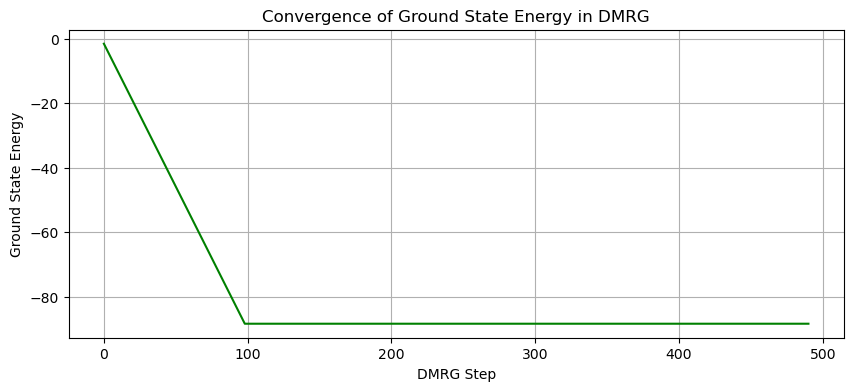

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(np.arange(0, len(energies)), energies[:], linestyle='-', color='green')
plt.xlabel('DMRG Step')
plt.ylabel('Ground State Energy')
plt.title('Convergence of Ground State Energy in DMRG')
plt.grid(True)
plt.show()